# Introduction

This Jupyter Notebook looks at the rates of diagnosis of depression in Birmingham. 

The original data sources it uses are:

- [A breakdown of the number of patients in each gp practice by the lsoa they are registered as living in](
https://digital.nhs.uk/data-and-information/publications/statistical/patients-registered-at-a-gp-practice/january-2018)

- [Indices of Multiple Deprivation - 2015. Data that gives the Index of Multiple Deprivation rank and decile for Lower Super Output Areas](https://www.gov.uk/government/statistics/english-indices-of-deprivation-2015)

- [Quality Outcome Framework data that gives the prevalence rates for the diagnosis of 21 medical conditions by gp practice](https://digital.nhs.uk/data-and-information/publications/statistical/quality-and-outcomes-framework-achievement-prevalence-and-exceptions-data/quality-and-outcomes-framework-qof-2016-17)

- [Ethnicity breakdown at lower super output area level based on data from the 2011 census on the NOMIS website](https://www.nomisweb.co.uk)*

We first built a data model that calculated estimated rates for the diagnosis of conditions at lsoa level. We have documented both [the process](http://dataunlocked.co.uk/estimating-the-diagnosis-of-health-conditions/) and [the SQL used](http://dataunlocked.co.uk/how-to-estimate-the-diagnosis-of-health-conditions-in-england/) to create the data model on the Data Unlocked blog.

After generating these estimates a [Tableau visualisation was created](https://public.tableau.com/profile/mikelcu#!/vizhome/BirminghamQOFbyLSOA/Map) which showed that more deprived areas in central Birmingham appeared to have a lower diagnosis rate for depression than both more affluent areas and deprived areas outside the inner city. 
The more deprived areas of central Birmingham are more ethnically diverse than both its more affluent areas and the deprived areas outside the inner city. Because of this we decided to investigate what the influences of deprivation and ethnicity might be in the diagnosis of depression in Birmingham.

## Notes on factors that may affects the accuracy of this analysis

The NOMIS site includes the following explanatory text
>“In order to protect against disclosure of personal information, records have been swapped between different geographic areas. Some counts will be affected, particularly small counts at the lowest geographies”

this may affect our analysis in ways that we are unable to quantify at the moment.

# Data Exploration

First, we import the libraries that we are going to be using.

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np

#Import visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pylab as pl

The following code suppresses the use of scientific float notation in Jupyter notebooks. It makes the analysis easier to follow. 

In [2]:
%matplotlib inline
np.set_printoptions(precision=5, suppress=True) 

Now we import the data file into a Pandas Dataframe, df. 

In [3]:
df = pd.read_csv('./lsoa_prevalence_bham_dep_baselined.csv', sep='\s*,\s*', header=0, encoding='ascii', engine='python')

Next we take a look at the first five rows in the DataFrame.

In [4]:
df.head()

,lsoa,imd_rank,imd_decile,indicator_group,estimated_pats_with_condition,All_ethnicities,White,Gypsy_traveller,Mixed_Ethnicity,Indian,Pakistani,Bangladeshi,Chinese,Other_Asian,Black_African_Caribbean,Other,group_desc,list_type,patients,ward_name
0,E01009417,22255,7,DEP,81.437118,1493,1338,0,26,68,4,0,1,14,27,15,Depression,18OV,1647,Sutton Four Oaks
1,E01009418,14654,5,DEP,82.308745,1471,1308,1,42,49,22,0,2,18,28,1,Depression,18OV,1635,Sutton Four Oaks
2,E01009419,18033,6,DEP,79.739249,1322,1192,1,17,70,9,6,1,1,13,12,Depression,18OV,1523,Sutton Four Oaks
3,E01009433,29446,9,DEP,90.585044,1759,1554,0,29,108,6,5,4,3,45,5,Depression,18OV,1863,Sutton Four Oaks
4,E01009415,30694,10,DEP,89.069990,1638,1485,1,33,63,25,2,7,13,7,2,Depression,18OV,1782,Sutton Four Oaks


The data fields consist of

| Data Field | Description | Source |
| :--- | :--- | :--- |
| lsoa | The code for the lower super output area | Office for National Statistics |
| imd_rank | The rank in the index of multiple deprivation that the lsoa is in | Office for National Statistics |
| imd_decile | The decile of the index of multiple deprivation that the lsoa is in | Office for National Statistics |
| indicator_group | The code for the condition being measured | Quality Outcome Frameworks |
| estimated_pats_with_condition | Estimated number of patients diagnosed with depression in this lsoa | Data Unlocked calculated field |
| All_ethnicities | Total number of people in lsoa | Office for National Statistics |
| White	 | Number of people self-identifying to be of White ethnic group in lsoa | Office for National Statistics |
| Gypsy_Traveller  | Number of people self-identifying to be of Gypsy Traveller ethnic group in lsoa | Office for National Statistics |	
| Mixed_Ethnicity  | Number of people self-identifying to be of mixed ethnic group in lsoa | Office for National Statistics |
| Indian  | Number of people self-identifying to be of Indian ethnic group in lsoa | Office for National Statistics |
| Bangladeshi | Number of people self-identifying to be of Bangladeshi ethnic group in lsoa | Office for National Statistics |
| Chinese  | Number of people self-identifying to be of Chinese ethnic group in lsoa | Office for National Statistics |	
| Pakistani	 | Number of people self-identifying to be of Pakistani ethnic group in lsoa | Office for National Statistics |
| Other_Asian  | Number of people self-identifying to be of an other Asian  ethnic group in lsoa | Office for National Statistics |
| Black_African_Caribbean  | Number of people self-identifying to be of Black-African-Caribbean ethnic group in lsoa | Office for National Statistics |	
| Other	 | Number of people self-identifying to be of an other ethnic group in lsoa | Office for National Statistics |
| group_desc	| Name for the condition  | Quality Outcome Frameworks |
| list_type	| The subset of patients who are surveyed for this condition  | Quality Outcome Frameworks |
| patients	| The total number of patients in the lsoa | Quality Outcome Frameworks |
| ward_name | The name of the local authority ward that this lsoa is in | 






We have twenty columns in total. Of those we will not be using lsoa, indicator_group, group_desc, list_type, patients or ward_name. 

imd_decile and imd_rank represent more and less coarsely grained information about the relative deprivation of the lsoa. In the first instance we will be using imd_decile, which is a categorisation feature. It places each lsoa on a scale of 1 to 10 with 1 being the most deprived areas and 10 the least.

Now we take a look at the composition of the table. Our data preparation has ensured that the columns are all complete. We have also performed some pre-processing that created the estimated_pats_with_condition feature.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 20 columns):
lsoa                             639 non-null object
imd_rank                         639 non-null int64
imd_decile                       639 non-null int64
indicator_group                  639 non-null object
estimated_pats_with_condition    639 non-null float64
All_ethnicities                  639 non-null int64
White                            639 non-null int64
Gypsy_traveller                  639 non-null int64
Mixed_Ethnicity                  639 non-null int64
Indian                           639 non-null int64
Pakistani                        639 non-null int64
Bangladeshi                      639 non-null int64
Chinese                          639 non-null int64
Other_Asian                      639 non-null int64
Black_African_Caribbean          639 non-null int64
Other                            639 non-null int64
group_desc                       639 non-null object
list_t

## People diagnosed with depression

First, let's see how many people of all ethnicities we have living in Birmingham, according to the ONS data.

In [6]:
df['All_ethnicities'].sum()

1073045

Next, let's take a look at how many people we (Data Unlocked) have estimated to have depression

In [7]:
int(df['estimated_pats_with_condition'].sum())

79676

Let's calculate that as a percentage

In [8]:
round((df['estimated_pats_with_condition'].sum()/1073045)*100, 2)

7.43

That gives us approximately 7.43% of the population of Birmingham with depression, according to our estimations.

At the moment the total population of 1073045 includes under 18 year olds, whereas the QOF data only provides figures for prevalence of the diagnosis of depression for adults aged 18 or over. As such the true percentage of adults diagnosed with depression will be considerably higher. LSOAs with a higher proportion of children under 18 will show as having a lower rate of diagnosis of depression too.

### By deprivation

Let's take a look at the estimated rates of diagnosis of depression across the deciles of the indices of multiple deprivation, where 1 is the most deprived and 10 is the least deprived.

First we create a new dataframe, imds, from the summation of the 'All' and "estimated_pats_with_condition" columns in df, grouped by 'imd_decile'. Then we calculate the percentages.

In [9]:
imds = pd.DataFrame(df.groupby(['imd_decile'])[["All_ethnicities", "estimated_pats_with_condition"]].sum())
imds['percentages'] = (imds["estimated_pats_with_condition"]/imds['All_ethnicities'])*100
imds = imds.round({'estimated_pats_with_condition':0, 'percentages':2})
imds

,All_ethnicities,estimated_pats_with_condition,percentages
imd_decile,,,
1,441015,32402.0,7.35
2,163382,12879.0,7.88
3,117099,9089.0,7.76
4,99591,7216.0,7.25
5,103611,7650.0,7.38
6,41896,3144.0,7.50
7,44419,3479.0,7.83
8,21780,1373.0,6.30
9,23537,1425.0,6.06


And then we view the percentages in a bar chart.

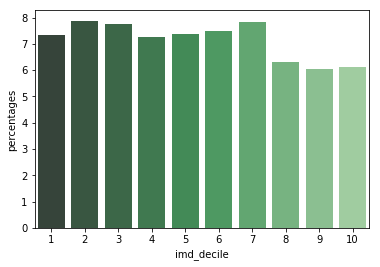

In [10]:
sns.barplot(x=imds.index, y=imds['percentages'], palette="Greens_d");

So, it certainly looks like people in the higher three imd_deciles are less likely to be diagnosed with depression. The variance in the percentages is fairly small though.

Once again, we note that these percentages are based on division by total population figures and so when we look at this again using the correct over-18 population figures we may see some changes to this breakdown.

### By lsoa

Next, we will look at the distribution of the estimated rate of the diagnosis of depression by lsoa. First, we calculate the rate of diagnosis as 'proportion_of_estimated_pats_with_condition'

In [11]:
#Prevalence of people with depression
df['proportion_of_estimated_pats_with_condition'] = df['estimated_pats_with_condition']/df['All_ethnicities']

We can now look at the distribution of the 'proportion_of_estimated_pats_with_condition' column.

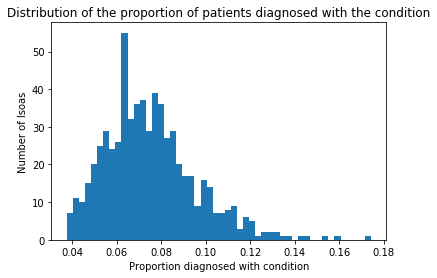

In [12]:
plt.hist(df['proportion_of_estimated_pats_with_condition'], bins = 50);
plt.xlabel('Proportion diagnosed with condition'); plt.ylabel('Number of lsoas'); 
plt.title('Distribution of the proportion of patients diagnosed with the condition');

So, we see that the distribution is right-skewed with a small number of lsoas that might be considered as outliers where the proportion is greater than 0.14.
We can look at these lsoas in particular using the following line of code

In [13]:
df.loc[df['proportion_of_estimated_pats_with_condition'] > 0.14]

,lsoa,imd_rank,imd_decile,indicator_group,estimated_pats_with_condition,All_ethnicities,White,Gypsy_traveller,Mixed_Ethnicity,Indian,...,Bangladeshi,Chinese,Other_Asian,Black_African_Caribbean,Other,group_desc,list_type,patients,ward_name,proportion_of_estimated_pats_with_condition
560,E01009160,322,1,DEP,244.261998,1586,1357,0,81,7,...,2,6,8,107,15,Depression,18OV,1780,Longbridge,0.154011
562,E01033633,2325,1,DEP,372.120358,2353,2038,1,139,6,...,0,4,7,133,7,Depression,18OV,3344,Longbridge,0.158147
579,E01009163,3374,2,DEP,253.120176,1452,1291,0,61,10,...,1,8,1,70,9,Depression,18OV,2270,Longbridge,0.174325
582,E01009159,13415,5,DEP,256.845440,1775,1603,0,45,30,...,1,13,11,51,5,Depression,18OV,2152,Longbridge,0.144702
583,E01009164,9268,3,DEP,213.457631,1484,1347,1,74,3,...,0,6,2,39,7,Depression,18OV,1596,Longbridge,0.143839


I have chosen to keep these in the data as I don't think they are significant enough outliers to exclude. It is worth noting that the five lsoas with the greatest proportion of patients estimated to have been diagnosed with depression are all in Longbridge and have a high proportion of residents who identify as being white.

## Ethnicity analysis

Let's take a look at the breakdown of ethnicities in Birmingham. First we create an array, 'columns_to_total' containing the ethnicity features in our dataframe. Next we total those columns up using the sum() operation, sorting for those totals.

In [14]:
columns_to_total = ["Bangladeshi", "Black_African_Caribbean", "Chinese", "Gypsy_traveller", "Indian", "Mixed_Ethnicity", "Other", "Other_Asian", "Pakistani", "White","All_ethnicities"]
ethnicity_totals = pd.DataFrame((df[columns_to_total].sum()).sort_values(), columns = ['totals'])
ethnicity_totals

,totals
Gypsy_traveller,408
Chinese,12712
Other,21804
Other_Asian,31148
Bangladeshi,32532
Mixed_Ethnicity,47605
Indian,64621
Black_African_Caribbean,96360
Pakistani,144627
White,621228


A quick sanity check tells us that the individual totals add up to the figure against 'All_ethnicities'. 

The 'patients' feature is taken from the Quality Outcome Frameworks statistics. Summing that we get

In [15]:
df['patients'].sum()

1256487

which is considerably more than the total for 'All_ethnicities'.

It is useful for us to look at the percentages of ethnicities as well as their totals. To do this we will drop the 'All' row and then do the calculation. This time we will display the rows in descending order of the totals.

In [16]:
ethnicity_totals = ethnicity_totals.drop(['All_ethnicities'])

In [17]:
ethnicity_totals['percentages']= 100*ethnicity_totals['totals']/ethnicity_totals['totals'].sum()
ethnicity_totals= ethnicity_totals.round({'percentages':2})
ethnicity_totals.sort_values(by=['totals'], ascending = False)

,totals,percentages
White,621228,57.89
Pakistani,144627,13.48
Black_African_Caribbean,96360,8.98
Indian,64621,6.02
Mixed_Ethnicity,47605,4.44
Bangladeshi,32532,3.03
Other_Asian,31148,2.90
Other,21804,2.03
Chinese,12712,1.18
Gypsy_traveller,408,0.04


This shows us that over 50% of the population of Birmingham declares itself to be from a white ethnic group. We can now display this visually using a pie chart.

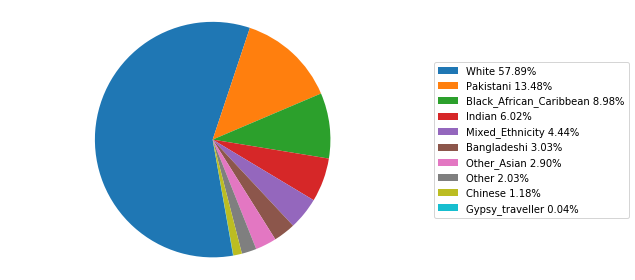

In [18]:
explode = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1) 
sizes = [57.89, 13.48, 8.98, 6.02, 4.44, 3.03,2.90, 2.03, 1.18, 0.04]
labels = ["White 57.89%", "Pakistani 13.48%", "Black_African_Caribbean 8.98%", "Indian 6.02%", "Mixed_Ethnicity 4.44%", "Bangladeshi 3.03%", "Other_Asian 2.90%", "Other 2.03%", "Chinese 1.18%", "Gypsy_traveller 0.04%"]
patches, texts = plt.pie(sizes, startangle=280, counterclock=False)
plt.legend(patches, labels, bbox_to_anchor=(1.05, 0.8),  borderaxespad=0.)
plt.axis('equal')
plt.tight_layout()
plt.show()

## Deprivation analysis

The [Uk's Gov.uk site](https://www.gov.uk/government/statistics/english-indices-of-deprivation-2015) describes its Indices of Multiple Deprivation statistics as follows:

"The English indices of deprivation measure relative deprivation in small areas in England called lower-layer super output areas." 

Typically these areas have between 1000 and 3000 people living within them. They are the smallest areas that statistics are collected on a wide ranging basis. By estimating the number of people diagnosed with health conditions within lower-layer super output areas we are able to make further comparisons against such statistics (in this case ethnicity).

First, we take a look at the spread of imd deciles in Birmingham.

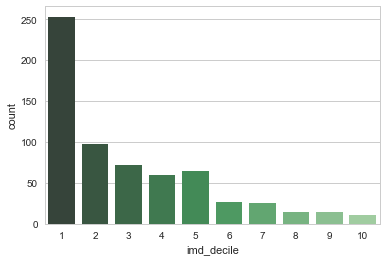

In [19]:
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x="imd_decile", data=df, palette="Greens_d")

IMD deciles run from 1 - the most economically deprived to 10 - the most economically affluent.

Birmingham has a high number of lsoas in the first decile. Over 50% of Birmingham lsoas fall in the first two deciles. From this we can see that Birmingham is relatively economically deprived, compared with the whole of England.

Finally, we can see that the mean average IMD decile in Birmingham is 3.0 (to two decimal places)

In [20]:
round(df.imd_decile.mean(), 2)

3.0

## Calculating Proportions

At the moment we have the totals for people from different ethnicities in each lsoa. The population of an lsoa is not the same across all lsoas. In order to make any kind of comparisons then we really want to be using proportions rather than totals.

First, we create the features with the proportions.

In [21]:
#Ethnicity proportions
df['BangladeshiProp'] = df['Bangladeshi']/df['All_ethnicities']
df['Black_African_CaribbeanProp'] = df['Black_African_Caribbean']/df['All_ethnicities']
df['ChineseProp'] = df['Chinese']/df['All_ethnicities']
df['Gypsy_TravellerProp'] = df['Gypsy_traveller']/df['All_ethnicities']
df['IndianProp'] = df['Indian']/df['All_ethnicities']
df['Mixed_EthnicityProp'] = df['Mixed_Ethnicity']/df['All_ethnicities']
df['OtherProp'] = df['Other']/df['All_ethnicities']
df['Other_AsianProp'] = df['Other_Asian']/df['All_ethnicities']
df['PakistaniProp'] = df['Pakistani']/df['All_ethnicities']
df['WhiteProp'] = df['White']/df['All_ethnicities']

Next we drop the original features containing the totals.

In [22]:
#Drop original ethnicity columns
df = df.drop(['Bangladeshi'], axis=1)
df = df.drop(['Black_African_Caribbean'], axis=1)
df = df.drop(['Chinese'], axis=1)
df = df.drop(['Gypsy_traveller'], axis=1)
df = df.drop(['Indian'], axis=1)
df = df.drop(['Mixed_Ethnicity'], axis=1)
df = df.drop(['Other'], axis=1)
df = df.drop(['Other_Asian'], axis=1)
df = df.drop(['Pakistani'], axis=1)
df = df.drop(['White'], axis=1)
#Drop original prevalence column
df = df.drop(['estimated_pats_with_condition'], axis=1)

In [23]:
df.head()

,lsoa,imd_rank,imd_decile,indicator_group,All_ethnicities,group_desc,list_type,patients,ward_name,proportion_of_estimated_pats_with_condition,BangladeshiProp,Black_African_CaribbeanProp,ChineseProp,Gypsy_TravellerProp,IndianProp,Mixed_EthnicityProp,OtherProp,Other_AsianProp,PakistaniProp,WhiteProp
0,E01009417,22255,7,DEP,1493,Depression,18OV,1647,Sutton Four Oaks,0.054546,0.000000,0.018084,0.000670,0.000000,0.045546,0.017415,0.010047,0.009377,0.002679,0.896182
1,E01009418,14654,5,DEP,1471,Depression,18OV,1635,Sutton Four Oaks,0.055954,0.000000,0.019035,0.001360,0.000680,0.033311,0.028552,0.000680,0.012237,0.014956,0.889191
2,E01009419,18033,6,DEP,1322,Depression,18OV,1523,Sutton Four Oaks,0.060317,0.004539,0.009834,0.000756,0.000756,0.052950,0.012859,0.009077,0.000756,0.006808,0.901664
3,E01009433,29446,9,DEP,1759,Depression,18OV,1863,Sutton Four Oaks,0.051498,0.002843,0.025583,0.002274,0.000000,0.061399,0.016487,0.002843,0.001706,0.003411,0.883457
4,E01009415,30694,10,DEP,1638,Depression,18OV,1782,Sutton Four Oaks,0.054377,0.001221,0.004274,0.004274,0.000611,0.038462,0.020147,0.001221,0.007937,0.015263,0.906593


Next, we drop the columns that will not be used in a correlation.

In [24]:
df = df.drop(['lsoa', 'indicator_group', 'group_desc', 'list_type', 'patients', 'ward_name'], axis=1)

In [25]:
df.head()

,imd_rank,imd_decile,All_ethnicities,proportion_of_estimated_pats_with_condition,BangladeshiProp,Black_African_CaribbeanProp,ChineseProp,Gypsy_TravellerProp,IndianProp,Mixed_EthnicityProp,OtherProp,Other_AsianProp,PakistaniProp,WhiteProp
0,22255,7,1493,0.054546,0.000000,0.018084,0.000670,0.000000,0.045546,0.017415,0.010047,0.009377,0.002679,0.896182
1,14654,5,1471,0.055954,0.000000,0.019035,0.001360,0.000680,0.033311,0.028552,0.000680,0.012237,0.014956,0.889191
2,18033,6,1322,0.060317,0.004539,0.009834,0.000756,0.000756,0.052950,0.012859,0.009077,0.000756,0.006808,0.901664
3,29446,9,1759,0.051498,0.002843,0.025583,0.002274,0.000000,0.061399,0.016487,0.002843,0.001706,0.003411,0.883457
4,30694,10,1638,0.054377,0.001221,0.004274,0.004274,0.000611,0.038462,0.020147,0.001221,0.007937,0.015263,0.906593


# Calculating Correlation

The final piece of initial analysis is to look at the correlation between features, with the usual caveat that [correlation does not imply causation](https://en.wikipedia.org/wiki/Correlation_does_not_imply_causation)

Using the Seaborn library, we create a heatmap for correlation between our features. Here we are using the default Pearson correlation coefficient which is a measure of the linear correlation between two variables. Read along the bottom row to see the correlation coefficients for features against the estimated_patients_with_condition coefficient.

Here we see that there is a strong, positive correlation between being white and being diagnosed with depression, with mixed ethnicity quite strong too. Bangladeshi and Pakistani show weaker, negative correlations.

This also shows positive correlation for non-white ethnicities living in the same lsoa. People identifying as white show a negative correlation for living with all other ethnicities.

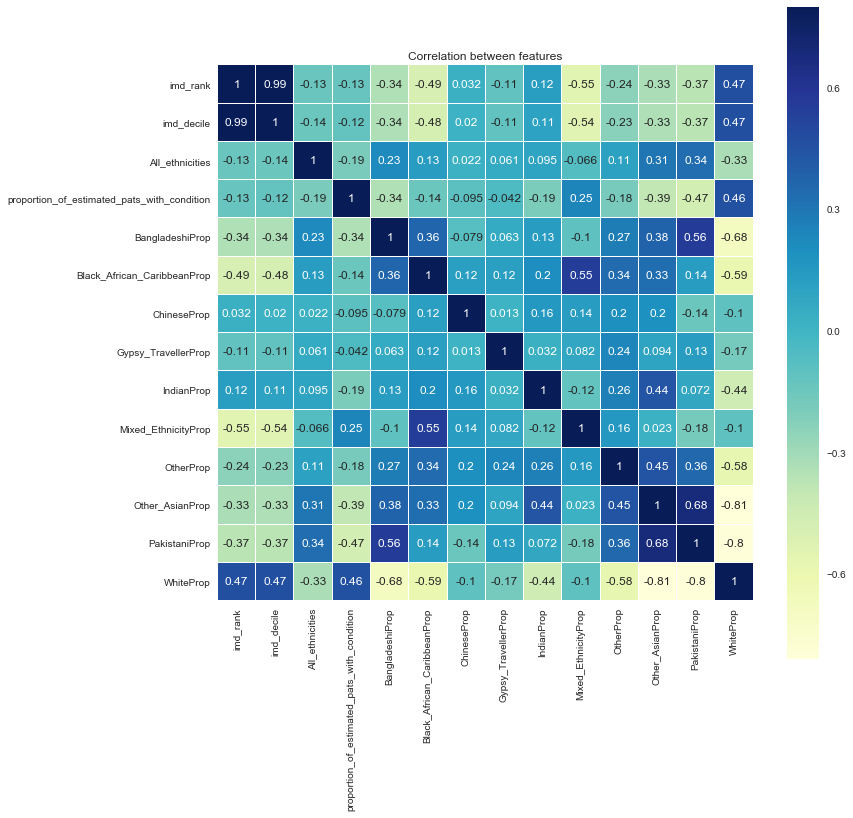

In [26]:
corr=df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

This next heatmap uses the Spearman correlation coefficient, which is a measure of monotonic correlation between two variables. The results are slightly different but largely reinforce the Pearson correlation results.

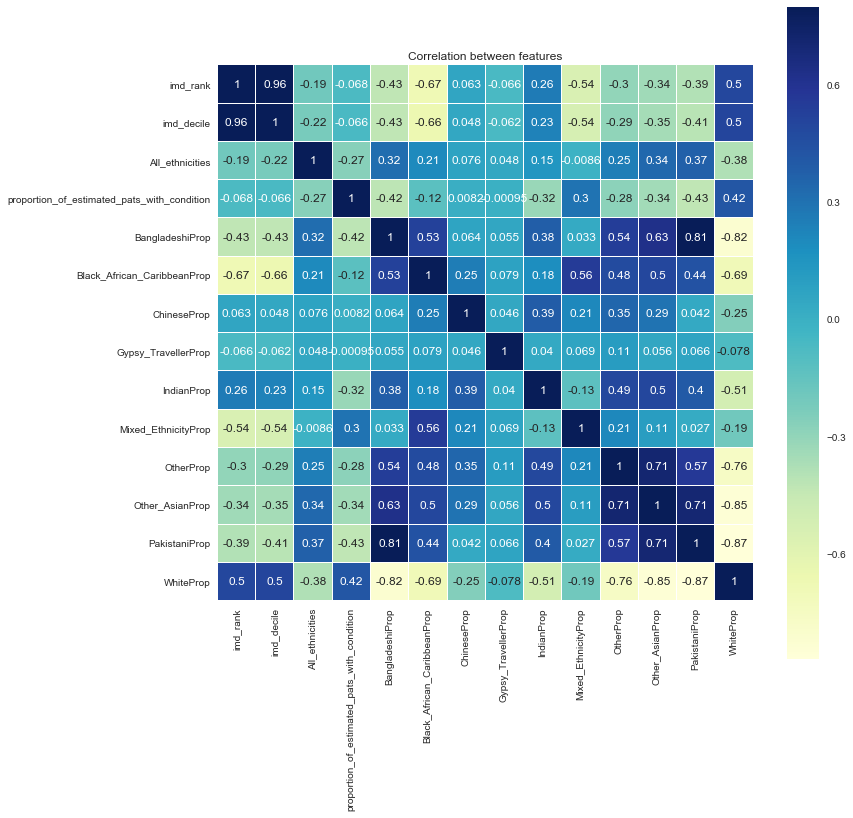

In [27]:
#corr=df.corr(method='spearman')
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(method='spearman'), vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

# Summary

We have estimated that almost 80,000 people in Birmingham have been diagnosed with depression. <br>
It is likely that people in the highest three deciles of the Indices of Multiple Deprivation are less likely to be diagnosed with depression. <br>
The five lsoas with the highest rate of diagnosis of depression are all in Longbridge. <br>
Over 50% of Birmingham lsoas fall in the first two deciles of the Indices of Multiple Deprivation. <br>
There is a positive correlation for non-white ethnicities living in the same lsoa. <br>
There is a negative correlation for people identifying as white living with all other ethnicities. <br>
There is a strong, positive correlation between an losa having a large proportion of white residents and there being a higher rate of diagnosis of depression in that area. <br>
There is a strong, negative correlation between an losa having a large proportion of Bangladeshi and/or Pakistani residents and there being a higher rate of diagnosis of depression in that area. <br>

In [the next blog post in this series](http://localhost:8888/notebooks/Google%20Drive/qof/Birmingham%20Depression%20Clustering.ipynb) we will look at using clustering, a technique that uses machine learning technologies, to further analyse our data